## Fera Formidável 4.4
### No alto daquele monte vivia Carlos, o incerto
#### Rômulo 24024

### Enunciado:
**Objetivo:** implemente e compute a incerteza de previsão de uma rede neural utilizando a estratégia de Monte Carlo Dropout.

**Sugestão:** faça a tarefa “Derrube pra fora” antes de fazer esta.

### Introdução:
Monte Carlo Dropout é uma técnica que aplica o dropout não apenas durante o treinamento, mas também na fase de inferência. Isso permite realizar múltiplas passagens estocásticas pela rede, gerando uma distribuição de previsões. A partir dessa distribuição, é possível estimar a incerteza associada às previsões do modelo, o que é crucial em aplicações onde a confiabilidade é essencial, como diagnósticos médicos ou sistemas autônomos.

Vamos aplicar esta estratégia usando o código de dropout em Python puro e analizar as predições e suas variâncias.

#### Imports Necessários:

In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np

#### Classes em Python puro:
Vamos usar como base as classes da fera 4.3, já com dropout.

In [2]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = np.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        e_neg = (-self).exp()
        return Valor(1) / (Valor(1) + e_neg)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()
            
class Neuronio:
    def __init__(self, num_dados_entrada):
        self.status = 1
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  

        if self.status == 0: # Se essa probabilidade sorteada for menor que a taxa de dropout o neurônio será desligado
            dado_de_saida = Valor(0) 
        else:
            dado_de_saida = soma.sig()

        return dado_de_saida       
    
    def dropout(self,dropout):
        p = random.uniform(0,1)
        if p < dropout:
            self.status = 0
    
    def dropout_clear(self):
        self.status = 1
    
    def parametros(self):
        return self.pesos + [self.vies]
    
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  

    def dropout(self, dropout):
        for neuronio in self.neuronios:
            neuronio.dropout(dropout)
    
    def dropout_clear(self):
        for neuronio in self.neuronios:
            neuronio.dropout_clear()
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params
    
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x

    def dropout(self, dropout: float = 0):
        if dropout != 0:
            for i, camada in enumerate(self.camadas):
                if i != 0 and i != len(self.camadas) - 1:
                    camada.dropout(dropout)
    
    def dropout_clear(self):
        for camada in self.camadas:
            camada.dropout_clear()

    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

Testando com os dados:

In [3]:
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

NUM_DADOS_DE_ENTRADA = 3  
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [3, 2]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

Fazendo as previsões do modelo com treinamento do dropout:

In [4]:
NUM_EPOCAS = 90
TAXA_DE_APRENDIZADO = 0.5
previsoes = []
for epoca in range(NUM_EPOCAS):
    minha_mlp.dropout(0.5)
    # forward pass
    y_pred = []
    for exemplo in x:
        previsao = minha_mlp(exemplo)
        y_pred.append(previsao)
    previsoes.append(y_pred) # estou armazenando as previsoes aqui para tirar a variância depois
    
    # loss
    erros = []
    for yt, yp in zip(y_true, y_pred):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico)        
    loss = sum(erros)
    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0

    # backpropagation
    loss.propagar_tudo()

    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

    minha_mlp.dropout_clear() # Restaura os neurônios dropados

    # mostra resultado (opcional)
    print(epoca, loss)

0 Valor(data=0.5882988720759291)
1 Valor(data=0.5734302998762272)
2 Valor(data=0.5758582815232239)
3 Valor(data=0.570040073108361)
4 Valor(data=0.5669904397679701)
5 Valor(data=0.5672945648839456)
6 Valor(data=0.5676049108892157)
7 Valor(data=0.5675605575453498)
8 Valor(data=0.5672684507400305)
9 Valor(data=0.5672378191767801)
10 Valor(data=0.5667086233909466)
11 Valor(data=0.5672358932744063)
12 Valor(data=0.5677173071477434)
13 Valor(data=0.5665894859957629)
14 Valor(data=0.5672413789686246)
15 Valor(data=0.5671787676810077)
16 Valor(data=0.5677445478423965)
17 Valor(data=0.5676409055557138)
18 Valor(data=0.5675812898958489)
19 Valor(data=0.5668563914779964)
20 Valor(data=0.5663386234788941)
21 Valor(data=0.5662688226448044)
22 Valor(data=0.5677768653010522)
23 Valor(data=0.5662505899202908)
24 Valor(data=0.5662557295346929)
25 Valor(data=0.5672892658351343)
26 Valor(data=0.5678205752545092)
27 Valor(data=0.5676845752149634)
28 Valor(data=0.5664559788428961)
29 Valor(data=0.567245101

Agora temos as previsões de cada modelo para as 4 amostras, todas com a mesma taxa de dropout.

In [5]:
previsoes

[[Valor(data=0.35109940594732897),
  Valor(data=0.3500363817454052),
  Valor(data=0.350805558261222),
  Valor(data=0.35181394746425765)],
 [Valor(data=0.38326556953621677),
  Valor(data=0.3819613641557072),
  Valor(data=0.3832353017332815),
  Valor(data=0.38338403776598673)],
 [Valor(data=0.37480800497745126),
  Valor(data=0.37282357865214366),
  Valor(data=0.37455368441708725),
  Valor(data=0.3753932532309021)],
 [Valor(data=0.3932244910678337),
  Valor(data=0.3915252400074093),
  Valor(data=0.3930215493104016),
  Valor(data=0.39363166445118947)],
 [Valor(data=0.413533727888459),
  Valor(data=0.4123343819116995),
  Valor(data=0.41345592951129573),
  Valor(data=0.4136016487800399)],
 [Valor(data=0.4076773931738078),
  Valor(data=0.40611158302326533),
  Valor(data=0.407488401772138),
  Valor(data=0.4079650088773244)],
 [Valor(data=0.43012130084098865),
  Valor(data=0.43012130084098865),
  Valor(data=0.43012130084098865),
  Valor(data=0.43012130084098865)],
 [Valor(data=0.428890936434514

Podemos plotá-los para analisar visualmente o comportamento entre as previsões.

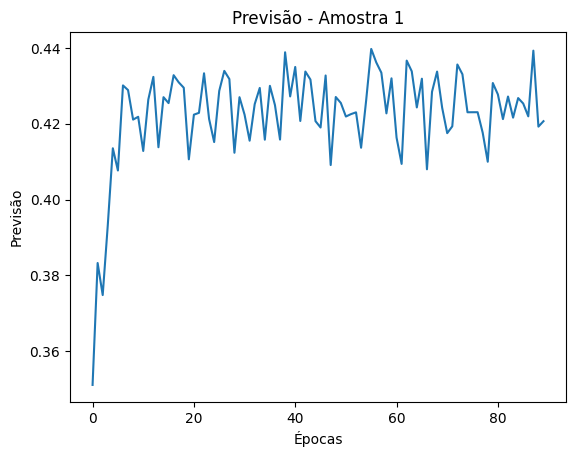

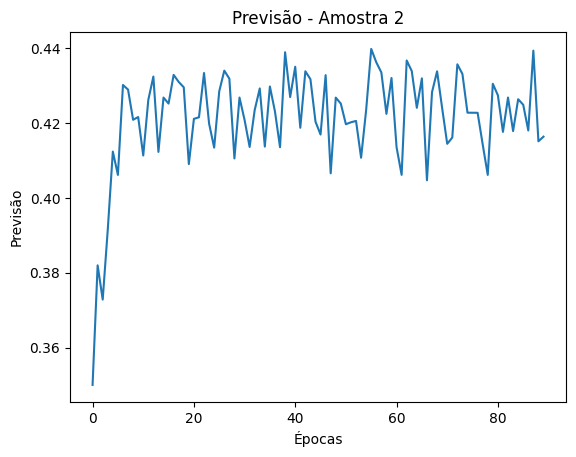

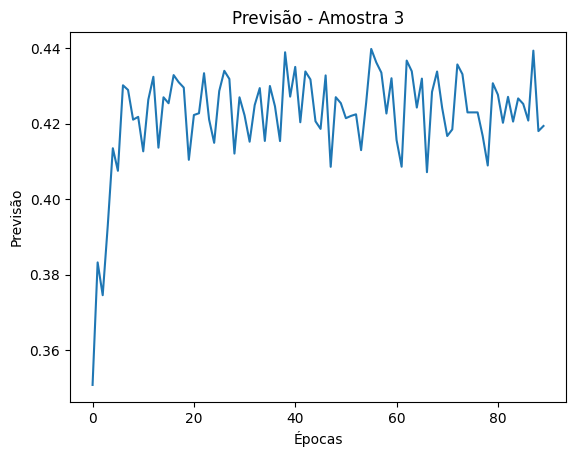

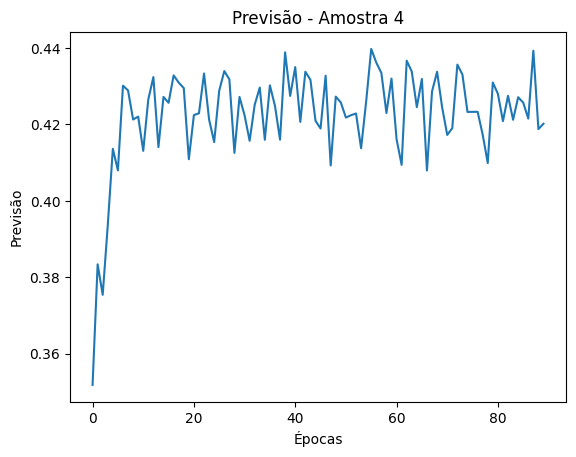

In [6]:
for i in range(len(y_true)):
    y_pred_i = [previsoes[j][i].data for j in range(len(previsoes))]
    plt.plot(y_pred_i, label=f'Amostra {i}')
    plt.title(f'Previsão - Amostra {i+1}')
    plt.xlabel('Épocas')
    plt.ylabel('Previsão')
    plt.show()


Analizando agora as variâncias:

In [7]:
variancias = []
for i in range(len(y_true)):
    y_pred_i = [previsoes[j][i].data for j in range(len(previsoes))]
    media = sum(y_pred_i) / len(y_pred_i)
    variancia = sum((x - media) ** 2 for x in y_pred_i) / (len(y_pred_i) - 1)
    variancias.append(variancia)
    print(f'A variância de y_pred{i} foi de: {variancia:}')

A variância de y_pred0 foi de: 0.00017281491284466054
A variância de y_pred1 foi de: 0.00018974812554387464
A variância de y_pred2 foi de: 0.0001758466902247914
A variância de y_pred3 foi de: 0.0001708618323849148


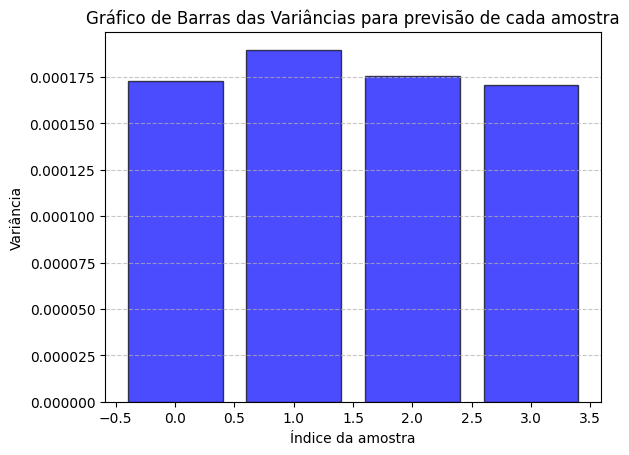

In [8]:
plt.bar(range(len(variancias)), variancias, color='b', alpha=0.7, edgecolor='black')
plt.title('Gráfico de Barras das Variâncias para previsão de cada amostra')
plt.xlabel('Índice da amostra')
plt.ylabel('Variância')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

A variância está bastante baixa, o que nos indica que o modelo é confiável para os dados de treino.

### Conclusão:
O código implementa uma rede neural do tipo MLP (Perceptron Multicamadas) com dropout para calcular previsões e incertezas. A estratégia de Monte Carlo Dropout é utilizada para estimar a variância das previsões, que reflete a incerteza do modelo. 

A partir dos gráficos gerados, é possível observar como as previsões evoluem ao longo das épocas e comparar com os valores reais. A variância calculada para cada amostra fornece uma medida quantitativa da incerteza associada às previsões, sendo útil para avaliar a confiabilidade do modelo em diferentes cenários.

### Referências

- GEEKSFORGEEKS. What is Monte Carlo (MC) Dropout? 

Disponível em: <https://www.geeksforgeeks.org/what-is-monte-carlo-mc-dropout/>

- Classes da MLP em Python puro

 Obtidos em: ATP-303 NN 4.2 - Notebook MLP.ipynb